###Skin Cancer Detection with Machine Learning (Notebook 2)
Alyona Kosobokova, Matthew Ongcapin, Pawan Bishwokarma, Tommy Poole

# ***Optimized Training Configuration***

In [ ]:
!pip install torchmetrics
!pip install torcheval
!pip install -U albumentations colorama

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# ***Optimized Training Configuration***

In [ ]:
CONFIG = {
    "seed": 42,
    "epochs": 50,
    "img_size": 384,
    "model_name": "tf_efficientnet_b0_ns",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 1e-4,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

In [ ]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook for reproducibility.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # CuDNN settings for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Fixed value for hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

# Set the seed based on CONFIG
set_seed(CONFIG['seed'])

# Optional: Test reproducibility
print("Random test:", np.random.rand(3))  # Should always give the same result

Random test: [0.37454012 0.95071431 0.73199394]


In [ ]:
image_folder_path = "/content/drive/MyDrive/AAI_501_Group_2_Project_Folder/ISIC_Data/ISIC_2024_Permissive_Training_Input"

In [ ]:
import os

ROOT_DIR = ""
TRAIN_DIR = image_folder_path

def get_train_file_path(image_id):
    return os.path.join(TRAIN_DIR, f"{image_id}.jpg")
    # Load image file paths

train_images = set(glob.glob(f"{TRAIN_DIR}/*.jpg"))

# ***Read Data***

In [ ]:
METADATA_PATH = os.path.join("train-metadata.csv")

# Read metadata
df = pd.read_csv(METADATA_PATH)
print("Original shape:", df.shape)
print("Positive cases:", df["target"].sum())
print("Unique patients:", df["patient_id"].nunique())

# Separate positive and negative cases
df_positive = df.loc[df["target"] == 1].reset_index(drop=True)
df_negative = df.loc[df["target"] == 0].reset_index(drop=True)

# Balance dataset with a 1:20 positive:negative ratio
POS_NEG_RATIO = 20
df = pd.concat([df_positive, df_negative.iloc[:len(df_positive) * POS_NEG_RATIO]]).reset_index(drop=True)
print("Filtered shape:", df.shape)
print("Positive cases:", df["target"].sum())
print("Unique patients:", df["patient_id"].nunique())


Original shape: (401059, 55)
Positive cases: 393
Unique patients: 1042
Filtered shape: (8253, 55)
Positive cases: 393
Unique patients: 950


In [ ]:
df['file_path'] = df['isic_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590,/content/drive/MyDrive/AAI_501_Group_2_Project...
1,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170,/content/drive/MyDrive/AAI_501_Group_2_Project...
2,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,...,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270,/content/drive/MyDrive/AAI_501_Group_2_Project...
3,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Superficial",NaN,NaN,NaN,99.960846,/content/drive/MyDrive/AAI_501_Group_2_Project...
4,ISIC_0190307,1,IP_4890448,65.0,male,head/neck,6.10,TBP tile: close-up,3D: XP,36.467641,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,95.272583,/content/drive/MyDrive/AAI_501_Group_2_Project...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4352,ISIC_0267384,0,IP_6631830,45.0,male,anterior torso,2.60,TBP tile: close-up,3D: white,18.465400,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999700,/content/drive/MyDrive/AAI_501_Group_2_Project...
4353,ISIC_0267466,0,IP_3549978,35.0,female,anterior torso,2.81,TBP tile: close-up,3D: white,22.023513,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,/content/drive/MyDrive/AAI_501_Group_2_Project...
4354,ISIC_0267482,0,IP_1438784,50.0,male,lower extremity,2.62,TBP tile: close-up,3D: white,14.411303,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.142226,/content/drive/MyDrive/AAI_501_Group_2_Project...
4355,ISIC_0267560,0,IP_7746572,80.0,male,anterior torso,9.32,TBP tile: close-up,3D: white,18.481750,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.022320,/content/drive/MyDrive/AAI_501_Group_2_Project...


In [ ]:
df.shape[0], df.target.sum()

(4357, 76)

In [ ]:
CONFIG['T_max'] = df.shape[0] * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
CONFIG['T_max']

5446

# ***Creating folds***

In [ ]:
# Ensure the dataframe has the required columns
if 'target' not in df.columns or 'patient_id' not in df.columns:
    raise ValueError("DataFrame must contain 'target' and 'patient_id' columns")

# Initialize StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'])

# Add a 'kfold' column initialized to -1
df["kfold"] = -1

# Generate stratified group folds
for fold, (_, val_) in enumerate(sgkf.split(df, df.target, df.patient_id)):
    df.loc[val_, "kfold"] = int(fold)

# Ensure 'kfold' column is integer type
df["kfold"] = df["kfold"].astype(int)

print("Folds created successfully!")

Folds created successfully!


# ***Dataset Class***

In [ ]:
import os
import cv2
import random
from torch.utils.data import Dataset

class ISICDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None, img_size=CONFIG["img_size"]):
        # Separate positive and negative samples
        self.df_positive = df[df["target"] == 1].reset_index(drop=True)
        self.df_negative = df[df["target"] == 0].reset_index(drop=True)
        self.file_names_positive = self.df_positive['file_path'].values
        self.file_names_negative = self.df_negative['file_path'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.transforms = transforms
        self.img_size = img_size

    def __len__(self):
        # Balance dataset by doubling positive and negative samples
        return len(self.df_positive) * 2

    def __getitem__(self, index):
        # Randomly choose positive or negative sample
        if random.random() >= 0.5:
            file_names = self.file_names_positive
            targets = self.targets_positive
        else:
            file_names = self.file_names_negative
            targets = self.targets_negative

        # Ensure index wraps around
        index = index % len(file_names)

        # Load and preprocess image
        img_path = file_names[index]
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found at path: {img_path}")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))
        target = targets[index]

        # Apply transformations
        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'target': target
        }


class ISICDataset(Dataset):
    def __init__(self, df, transforms=None, img_size=CONFIG["img_size"]):
        self.df = df.reset_index(drop=True)
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms
        self.img_size = img_size

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load image and preprocess
        img_path = self.file_names[index]
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found at path: {img_path}")

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size, self.img_size))
        target = self.targets[index]

        # Apply transformations
        if self.transforms:
            img = self.transforms(image=img)["image"]

        return {
            'image': img,
            'target': target
        }


# ***Augmentations***

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),  # Ensure all images are the same size
        A.RandomRotate90(p=0.5),  # Random 90-degree rotations
        A.Flip(p=0.5),  # Random horizontal/vertical flips
        A.ShiftScaleRotate(
            shift_limit=0.05,  # Reduce shift to save computation
            scale_limit=0.1,   # Slight scaling for better efficiency
            rotate_limit=30,   # Reduce rotation limit
            p=0.5
        ),
        A.HueSaturationValue(
            hue_shift_limit=0.1,
            sat_shift_limit=0.1,
            val_shift_limit=0.1,
            p=0.5
        ),  # Subtle color augmentation
        A.RandomBrightnessContrast(
            brightness_limit=(-0.1, 0.1),
            contrast_limit=(-0.1, 0.1),
            p=0.5
        ),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0
        ),  # Normalize for pretrained model compatibility
        ToTensorV2()  # Convert to PyTorch tensor
    ], p=1.),

    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),  # Ensure consistent validation size
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            p=1.0
        ),  # Normalize
        ToTensorV2()  # Convert to PyTorch tensor
    ], p=1.)
}


# ***GeM Pooling***


In [ ]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        """
        Generalized Mean Pooling (GeM) layer for adaptive pooling.
        Args:
            p (float): Power parameter for pooling.
            eps (float): Epsilon to avoid numerical instability.
        """
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1) * p)  # Learnable power parameter
        self.eps = eps  # Epsilon to prevent division by zero

    def forward(self, x):
        """
        Forward pass for GeM pooling.
        Args:
            x (Tensor): Input tensor with shape (batch_size, channels, height, width).
        Returns:
            Tensor: Pooled tensor with shape (batch_size, channels, 1, 1).
        """
        return self.gem(x, self.p, self.eps)

    def gem(self, x, p=3, eps=1e-6):
        """
        Apply GeM pooling to the input tensor.
        Args:
            x (Tensor): Input tensor.
            p (float): Power parameter for pooling.
            eps (float): Epsilon to avoid numerical instability.
        Returns:
            Tensor: Pooled tensor.
        """
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

    def __repr__(self):
        """
        String representation of the GeM layer.
        """
        return f"{self.__class__.__name__}(p={self.p.data.tolist()[0]:.4f}, eps={self.eps})"

In [ ]:
# Example usage
gem_layer = GeM(p=3.0, eps=1e-6)
print(gem_layer)

# Input tensor [B, C, H, W]
x = torch.randn(8, 512, 7, 7)  # Example tensor

# Apply GeM pooling
output = gem_layer(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)


GeM(p=3.0000, eps=1e-06)
Input shape: torch.Size([8, 512, 7, 7])
Output shape: torch.Size([8, 512, 1, 1])


# ***Create a Model***

In [ ]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        """
        A custom model for ISIC classification using a pretrained backbone and GeM pooling.

        Args:
            model_name (str): Name of the model backbone (e.g., 'tf_efficientnet_b0_ns').
            num_classes (int): Number of output classes.
            pretrained (bool): Whether to use a pretrained backbone.
            checkpoint_path (str): Path to a checkpoint for the backbone. If None, default pretrained weights are used.
        """
        super(ISICModel, self).__init__()

        # Load pretrained backbone
        self.model = timm.create_model(model_name, pretrained=pretrained)

        # Load custom checkpoint if provided
        if checkpoint_path:
            print(f"Loading checkpoint from: {checkpoint_path}")
            self.model.load_state_dict(torch.load(checkpoint_path, map_location="cpu"))
        else:
            print("No checkpoint provided. Using default pretrained weights.")

        # Extract features and replace classifier
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()

        # Add custom pooling and classifier head
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        """
        Forward pass for the ISIC model.
        Args:
            images (Tensor): Input image tensor.
        Returns:
            Tensor: Output probabilities.
        """
        # Extract features using the backbone
        features = self.model(images)

        # Apply GeM pooling and flatten features
        pooled_features = self.pooling(features).flatten(1)

        # Pass through linear layer and sigmoid activation
        output = self.sigmoid(self.linear(pooled_features))
        return output

model = ISICModel(
    model_name=CONFIG['model_name'],
    num_classes=1,  # Binary classification
    pretrained=True,
    checkpoint_path=None  # Skip custom checkpoint
)
model.to(CONFIG['device']);


No checkpoint provided. Using default pretrained weights.


In [ ]:
def criterion(outputs, targets):
    """
    Computes Binary Cross-Entropy Loss for binary classification.

    Args:
        outputs (Tensor): Predicted probabilities from the model (values in range [0, 1]).
        targets (Tensor): Ground truth labels (binary, 0 or 1).

    Returns:
        Tensor: Computed loss value.
    """
    loss_fn = nn.BCELoss()  # Initialize Binary Cross-Entropy Loss
    return loss_fn(outputs, targets)


# ***Loss Function***

In [ ]:
def criterion(outputs, targets):
    """
    Computes the loss between model outputs and targets.
    Args:
        outputs (Tensor): Predicted outputs of shape [B, 1] (binary classification).
        targets (Tensor): Ground truth labels of shape [B, 1].
    Returns:
        Tensor: Computed loss.
    """
    return nn.BCEWithLogitsLoss()(outputs, targets)

# ***Training Function***

In [ ]:
from torchmetrics.classification import BinaryAUROC
from tqdm import tqdm
import gc

def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    """
    Trains the model for one epoch.

    Args:
        model (torch.nn.Module): The model to train.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler.
        dataloader (torch.utils.data.DataLoader): Dataloader for training data.
        device (torch.device): Device for training (CPU or GPU).
        epoch (int): Current epoch number.

    Returns:
        float: Average training loss for the epoch.
        float: Average AUROC score for the epoch.
    """
    model.train()

    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0

    # Initialize AUROC metric
    auroc_metric = BinaryAUROC().to(device)

    # Progress bar
    bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch}")
    for step, data in bar:
        # Move data to device
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)

        batch_size = images.size(0)

        # Forward pass
        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)

        # Accumulate loss for gradient accumulation
        loss = loss / CONFIG['n_accumulate']
        loss.backward()

        # Perform optimizer step after `n_accumulate` batches
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()
            optimizer.zero_grad()  # Zero gradients

            # Step scheduler if defined
            if scheduler is not None:
                scheduler.step()

        # Update AUROC metric
        auroc_metric.update(outputs.detach(), targets)

        # Update running statistics
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        # Calculate average loss and AUROC
        epoch_loss = running_loss / dataset_size
        epoch_auroc = auroc_metric.compute().item()

        # Update progress bar
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_AUROC=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])

    # Collect garbage to free memory
    gc.collect()

    return epoch_loss, epoch_auroc

# ***Validation Function***

In [ ]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    """
    Validates the model for one epoch.

    Args:
        model (torch.nn.Module): The model to validate.
        dataloader (torch.utils.data.DataLoader): Dataloader for validation data.
        device (torch.device): Device for validation (CPU or GPU).
        epoch (int): Current epoch number.

    Returns:
        float: Average validation loss for the epoch.
        float: Average AUROC score for the epoch.
    """
    model.eval()  # Set model to evaluation mode

    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0

    # Initialize AUROC metric
    auroc_metric = BinaryAUROC().to(device)

    # Progress bar
    bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Validation Epoch {epoch}")
    for step, data in bar:
        # Move data to device
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)

        batch_size = images.size(0)

        # Forward pass
        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)

        # Update AUROC metric
        auroc_metric.update(outputs, targets)

        # Update running statistics
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        # Calculate average loss
        epoch_loss = running_loss / dataset_size
        epoch_auroc = auroc_metric.compute().item()

        # Update progress bar
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_AUROC=epoch_auroc)

    # Free memory
    gc.collect()

    return epoch_loss, epoch_auroc


# ***Run Training***

In [ ]:
import time
import copy
import gc
from collections import defaultdict

def run_training(model, optimizer, scheduler, device, num_epochs):
    """
    Runs the training and validation process over multiple epochs.

    Args:
        model (torch.nn.Module): Model to train.
        optimizer (torch.optim.Optimizer): Optimizer for training.
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler.
        device (torch.device): Device for training (CPU or GPU).
        num_epochs (int): Number of epochs to train.

    Returns:
        model (torch.nn.Module): The model with the best weights based on validation AUROC.
        history (defaultdict): Dictionary containing training/validation metrics.
    """
    # GPU Info
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    start_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -float('inf')  # Initialize as negative infinity
    history = defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        gc.collect()  # Free memory

        # Training phase
        train_epoch_loss, train_epoch_auroc = train_one_epoch(
            model, optimizer, scheduler, dataloader=train_loader,
            device=device, epoch=epoch
        )

        # Validation phase
        val_epoch_loss, val_epoch_auroc = valid_one_epoch(
            model, dataloader=valid_loader, device=device, epoch=epoch
        )

        # Log metrics
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        # Save the best model
        if val_epoch_auroc > best_epoch_auroc:
            print(f"[INFO] Validation AUROC Improved ({best_epoch_auroc:.4f} ---> {val_epoch_auroc:.4f})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())

            # Save model checkpoint
            PATH = f"AUROC{val_epoch_auroc:.4f}_Loss{val_epoch_loss:.4f}_epoch{epoch}.bin"
            torch.save(model.state_dict(), PATH)
            print(f"[INFO] Model Saved at {PATH}")

        print()

    # Training complete
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training complete in {elapsed_time // 3600:.0f}h {(elapsed_time % 3600) // 60:.0f}m {(elapsed_time % 60):.0f}s")
    print(f"Best Validation AUROC: {best_epoch_auroc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, history


In [ ]:
def fetch_scheduler(optimizer):
    """
    Returns the learning rate scheduler based on the configuration.

    Args:
        optimizer (torch.optim.Optimizer): The optimizer for which the scheduler is configured.

    Returns:
        torch.optim.lr_scheduler: Configured learning rate scheduler or None.
    """
    scheduler = None

    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=CONFIG['T_max'],  # Maximum number of iterations
            eta_min=CONFIG['min_lr']  # Minimum learning rate
        )
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=CONFIG.get('T_0', 10),  # Number of iterations for the first restart
            eta_min=CONFIG['min_lr']  # Minimum learning rate
        )
    elif CONFIG['scheduler'] is None:
        print("[INFO] No scheduler used.")

    return scheduler

In [ ]:
def prepare_loaders(df, fold):
    """
    Prepares the train and validation DataLoaders for a given fold.

    Args:
        df (pd.DataFrame): DataFrame containing dataset information, including kfold column.
        fold (int): Fold number to use for validation.

    Returns:
        tuple: Train DataLoader and Validation DataLoader.
    """

    # Split data into training and validation based on the fold
    df_train = df[df.kfold != fold].reset_index(drop=False)
    df_valid = df[df.kfold == fold].reset_index(drop=False)

    # Create datasets
    train_dataset = ISICDataset_for_Train(df_train, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['train_batch_size'],
        num_workers=2,  # Adjust for your system
        shuffle=True,
        pin_memory=torch.cuda.is_available(),  # Use pinned memory for GPU
        drop_last=False  # Ensure batch consistency
    )

    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CONFIG['valid_batch_size'],
        num_workers=2,  # Adjust for your system
        shuffle=False,
        pin_memory=torch.cuda.is_available()  # Use pinned memory for GPU
    )

    return train_loader, valid_loader

In [ ]:
train_loader, valid_loader = prepare_loaders(df, fold=CONFIG["fold"])


# ***Define Optimizer and Scheduler***

In [ ]:
from torch.optim import Adam
from torch.optim import lr_scheduler

# Define Optimizer
optimizer = Adam(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Fetch Scheduler
scheduler = fetch_scheduler(optimizer)


# ***Checklist Before Starting Training***

In [ ]:
print(f"Model initialized on: {CONFIG['device']}")


Model initialized on: cuda:0


In [ ]:
print(f"Training with {CONFIG['epochs']} epochs, batch size {CONFIG['train_batch_size']}, learning rate {CONFIG['learning_rate']}")


Training with 50 epochs, batch size 32, learning rate 0.0001


In [ ]:
if scheduler:
    print(f"Scheduler: {CONFIG['scheduler']} is initialized with T_max={CONFIG.get('T_max', None)}")


Scheduler: CosineAnnealingLR is initialized with T_max=5446


# ***Training Start***

In [ ]:
model, history = run_training(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    device=CONFIG['device'],
    num_epochs=CONFIG['epochs']
)


[INFO] Using GPU: Tesla T4



Validation Epoch 1: 100%|██████████| 14/14 [00:13<00:00,  1.04it/s, Epoch=1, Valid_AUROC=0.564, Valid_Loss=1.01]


[INFO] Validation AUROC Improved (-inf ---> 0.5639)
[INFO] Model Saved at AUROC0.5639_Loss1.0122_epoch1.bin



Validation Epoch 2: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s, Epoch=2, Valid_AUROC=0.522, Valid_Loss=0.862]


Validation Epoch 3: 100%|██████████| 14/14 [00:07<00:00,  1.76it/s, Epoch=3, Valid_AUROC=0.583, Valid_Loss=0.794]


[INFO] Validation AUROC Improved (0.5639 ---> 0.5833)
[INFO] Model Saved at AUROC0.5833_Loss0.7936_epoch3.bin



Validation Epoch 4: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, Epoch=4, Valid_AUROC=0.621, Valid_Loss=0.769]


[INFO] Validation AUROC Improved (0.5833 ---> 0.6209)
[INFO] Model Saved at AUROC0.6209_Loss0.7691_epoch4.bin



Validation Epoch 5: 100%|██████████| 14/14 [00:12<00:00,  1.15it/s, Epoch=5, Valid_AUROC=0.629, Valid_Loss=0.781]


[INFO] Validation AUROC Improved (0.6209 ---> 0.6293)
[INFO] Model Saved at AUROC0.6293_Loss0.7814_epoch5.bin



Validation Epoch 6: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s, Epoch=6, Valid_AUROC=0.584, Valid_Loss=0.839]


Validation Epoch 7: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s, Epoch=7, Valid_AUROC=0.536, Valid_Loss=0.883]


Validation Epoch 8: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s, Epoch=8, Valid_AUROC=0.562, Valid_Loss=0.902]


Validation Epoch 9: 100%|██████████| 14/14 [00:13<00:00,  1.06it/s, Epoch=9, Valid_AUROC=0.591, Valid_Loss=0.89]


Validation Epoch 10: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s, Epoch=10, Valid_AUROC=0.621, Valid_Loss=0.877]


Validation Epoch 11: 100%|██████████| 14/14 [00:09<00:00,  1.47it/s, Epoch=11, Valid_AUROC=0.659, Valid_Loss=0.848]


[INFO] Validation AUROC Improved (0.6293 ---> 0.6586)
[INFO] Model Saved at AUROC0.6586_Loss0.8477_epoch11.bin



Validation Epoch 12: 100%|██████████| 14/14 [00:08<00:00,  1.68it/s, Epoch=12, Valid_AUROC=0.664, Valid_Loss=0.826]


[INFO] Validation AUROC Improved (0.6586 ---> 0.6638)
[INFO] Model Saved at AUROC0.6638_Loss0.8258_epoch12.bin



Validation Epoch 13: 100%|██████████| 14/14 [00:09<00:00,  1.50it/s, Epoch=13, Valid_AUROC=0.678, Valid_Loss=0.819]


[INFO] Validation AUROC Improved (0.6638 ---> 0.6776)
[INFO] Model Saved at AUROC0.6776_Loss0.8194_epoch13.bin



Validation Epoch 14: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s, Epoch=14, Valid_AUROC=0.693, Valid_Loss=0.81]


[INFO] Validation AUROC Improved (0.6776 ---> 0.6931)
[INFO] Model Saved at AUROC0.6931_Loss0.8101_epoch14.bin



Validation Epoch 15: 100%|██████████| 14/14 [00:12<00:00,  1.14it/s, Epoch=15, Valid_AUROC=0.717, Valid_Loss=0.812]


[INFO] Validation AUROC Improved (0.6931 ---> 0.7166)
[INFO] Model Saved at AUROC0.7166_Loss0.8124_epoch15.bin



Validation Epoch 16: 100%|██████████| 14/14 [00:12<00:00,  1.11it/s, Epoch=16, Valid_AUROC=0.733, Valid_Loss=0.825]


[INFO] Validation AUROC Improved (0.7166 ---> 0.7326)
[INFO] Model Saved at AUROC0.7326_Loss0.8255_epoch16.bin



Validation Epoch 17: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s, Epoch=17, Valid_AUROC=0.754, Valid_Loss=0.846]


[INFO] Validation AUROC Improved (0.7326 ---> 0.7537)
[INFO] Model Saved at AUROC0.7537_Loss0.8463_epoch17.bin



Validation Epoch 18: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s, Epoch=18, Valid_AUROC=0.758, Valid_Loss=0.849]


[INFO] Validation AUROC Improved (0.7537 ---> 0.7582)
[INFO] Model Saved at AUROC0.7582_Loss0.8494_epoch18.bin



Validation Epoch 19: 100%|██████████| 14/14 [00:08<00:00,  1.56it/s, Epoch=19, Valid_AUROC=0.77, Valid_Loss=0.816]


[INFO] Validation AUROC Improved (0.7582 ---> 0.7698)
[INFO] Model Saved at AUROC0.7698_Loss0.8159_epoch19.bin



Validation Epoch 20: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, Epoch=20, Valid_AUROC=0.767, Valid_Loss=0.809]


Validation Epoch 21: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s, Epoch=21, Valid_AUROC=0.771, Valid_Loss=0.79]


[INFO] Validation AUROC Improved (0.7698 ---> 0.7707)
[INFO] Model Saved at AUROC0.7707_Loss0.7901_epoch21.bin



Validation Epoch 22: 100%|██████████| 14/14 [00:13<00:00,  1.01it/s, Epoch=22, Valid_AUROC=0.761, Valid_Loss=0.796]


Validation Epoch 23: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s, Epoch=23, Valid_AUROC=0.761, Valid_Loss=0.784]


Validation Epoch 24: 100%|██████████| 14/14 [00:09<00:00,  1.54it/s, Epoch=24, Valid_AUROC=0.766, Valid_Loss=0.785]


Validation Epoch 25: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, Epoch=25, Valid_AUROC=0.771, Valid_Loss=0.785]


Validation Epoch 26: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s, Epoch=26, Valid_AUROC=0.772, Valid_Loss=0.779]


[INFO] Validation AUROC Improved (0.7707 ---> 0.7716)
[INFO] Model Saved at AUROC0.7716_Loss0.7790_epoch26.bin



Validation Epoch 27: 100%|██████████| 14/14 [00:12<00:00,  1.09it/s, Epoch=27, Valid_AUROC=0.773, Valid_Loss=0.796]


[INFO] Validation AUROC Improved (0.7716 ---> 0.7729)
[INFO] Model Saved at AUROC0.7729_Loss0.7955_epoch27.bin



Validation Epoch 28: 100%|██████████| 14/14 [00:13<00:00,  1.05it/s, Epoch=28, Valid_AUROC=0.774, Valid_Loss=0.815]


[INFO] Validation AUROC Improved (0.7729 ---> 0.7745)
[INFO] Model Saved at AUROC0.7745_Loss0.8146_epoch28.bin



Validation Epoch 29: 100%|██████████| 14/14 [00:13<00:00,  1.07it/s, Epoch=29, Valid_AUROC=0.772, Valid_Loss=0.824]


Validation Epoch 30: 100%|██████████| 14/14 [00:09<00:00,  1.53it/s, Epoch=30, Valid_AUROC=0.776, Valid_Loss=0.814]


[INFO] Validation AUROC Improved (0.7745 ---> 0.7756)
[INFO] Model Saved at AUROC0.7756_Loss0.8139_epoch30.bin



Validation Epoch 31: 100%|██████████| 14/14 [00:09<00:00,  1.53it/s, Epoch=31, Valid_AUROC=0.783, Valid_Loss=0.812]


[INFO] Validation AUROC Improved (0.7756 ---> 0.7832)
[INFO] Model Saved at AUROC0.7832_Loss0.8117_epoch31.bin



Validation Epoch 32: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s, Epoch=32, Valid_AUROC=0.787, Valid_Loss=0.796]


[INFO] Validation AUROC Improved (0.7832 ---> 0.7868)
[INFO] Model Saved at AUROC0.7868_Loss0.7955_epoch32.bin



Validation Epoch 33: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s, Epoch=33, Valid_AUROC=0.785, Valid_Loss=0.776]


Validation Epoch 34: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s, Epoch=34, Valid_AUROC=0.785, Valid_Loss=0.773]


Validation Epoch 35: 100%|██████████| 14/14 [00:13<00:00,  1.05it/s, Epoch=35, Valid_AUROC=0.792, Valid_Loss=0.792]


[INFO] Validation AUROC Improved (0.7868 ---> 0.7922)
[INFO] Model Saved at AUROC0.7922_Loss0.7919_epoch35.bin



Validation Epoch 36: 100%|██████████| 14/14 [00:13<00:00,  1.02it/s, Epoch=36, Valid_AUROC=0.794, Valid_Loss=0.778]


[INFO] Validation AUROC Improved (0.7922 ---> 0.7941)
[INFO] Model Saved at AUROC0.7941_Loss0.7779_epoch36.bin



Validation Epoch 37: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s, Epoch=37, Valid_AUROC=0.793, Valid_Loss=0.776]


Validation Epoch 38: 100%|██████████| 14/14 [00:13<00:00,  1.06it/s, Epoch=38, Valid_AUROC=0.792, Valid_Loss=0.767]


Validation Epoch 39: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s, Epoch=39, Valid_AUROC=0.787, Valid_Loss=0.766]


Validation Epoch 40: 100%|██████████| 14/14 [00:09<00:00,  1.50it/s, Epoch=40, Valid_AUROC=0.794, Valid_Loss=0.754]


[INFO] Validation AUROC Improved (0.7941 ---> 0.7943)
[INFO] Model Saved at AUROC0.7943_Loss0.7543_epoch40.bin



Validation Epoch 41: 100%|██████████| 14/14 [00:08<00:00,  1.66it/s, Epoch=41, Valid_AUROC=0.81, Valid_Loss=0.74]


[INFO] Validation AUROC Improved (0.7943 ---> 0.8104)
[INFO] Model Saved at AUROC0.8104_Loss0.7398_epoch41.bin



Validation Epoch 42: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s, Epoch=42, Valid_AUROC=0.818, Valid_Loss=0.734]


[INFO] Validation AUROC Improved (0.8104 ---> 0.8181)
[INFO] Model Saved at AUROC0.8181_Loss0.7338_epoch42.bin



Validation Epoch 43: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s, Epoch=43, Valid_AUROC=0.825, Valid_Loss=0.74]


[INFO] Validation AUROC Improved (0.8181 ---> 0.8247)
[INFO] Model Saved at AUROC0.8247_Loss0.7395_epoch43.bin



Validation Epoch 44: 100%|██████████| 14/14 [00:11<00:00,  1.20it/s, Epoch=44, Valid_AUROC=0.824, Valid_Loss=0.745]


Validation Epoch 45: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s, Epoch=45, Valid_AUROC=0.82, Valid_Loss=0.741]


Validation Epoch 46: 100%|██████████| 14/14 [00:08<00:00,  1.58it/s, Epoch=46, Valid_AUROC=0.818, Valid_Loss=0.743]


Validation Epoch 47: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s, Epoch=47, Valid_AUROC=0.816, Valid_Loss=0.752]


Validation Epoch 48: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s, Epoch=48, Valid_AUROC=0.818, Valid_Loss=0.768]


Validation Epoch 49: 100%|██████████| 14/14 [00:13<00:00,  1.04it/s, Epoch=49, Valid_AUROC=0.812, Valid_Loss=0.778]


Validation Epoch 50: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s, Epoch=50, Valid_AUROC=0.809, Valid_Loss=0.774]



Training complete in 0h 14m 1s
Best Validation AUROC: 0.8247


In [ ]:
history = pd.DataFrame.from_dict(history)

# ***Logs***


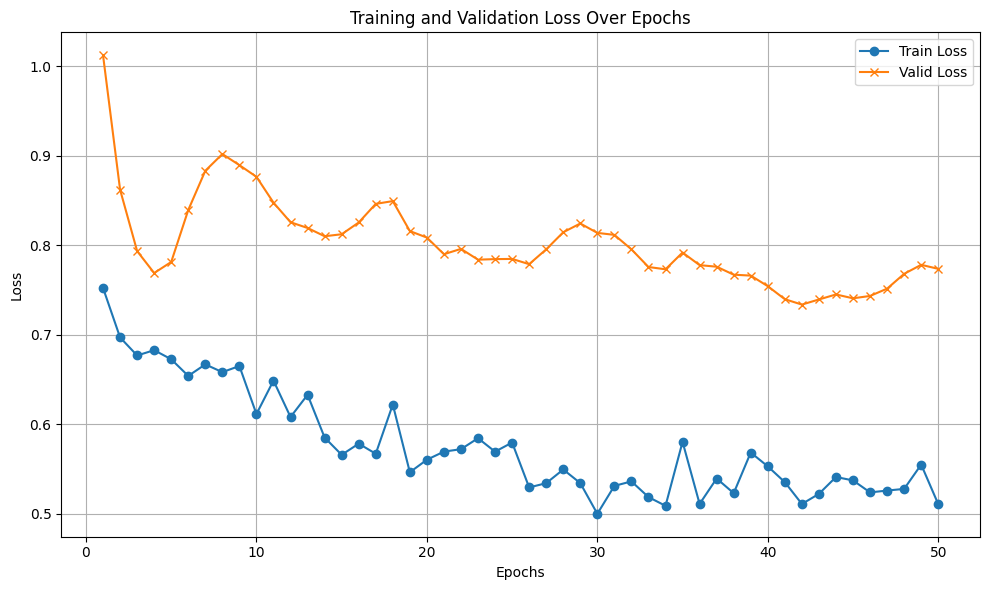

In [ ]:
# Plotting Training and Validation Loss
def plot_loss(history):
    """
    Plots the training and validation loss from the training history.

    Args:
        history (dict): Training history containing 'Train Loss' and 'Valid Loss' as keys.
    """
    plt.figure(figsize=(10, 6))  # Adjust the figure size
    epochs = range(1, len(history["Train Loss"]) + 1)  # Epochs start at 1

    # Plot Train and Validation Loss
    plt.plot(epochs, history["Train Loss"], label="Train Loss", marker='o')
    plt.plot(epochs, history["Valid Loss"], label="Valid Loss", marker='x')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.grid(True)
    plt.legend(loc="upper right")
    plt.tight_layout()  # Adjust layout to avoid clipping

    plt.show()

# Example Usage
plot_loss(history)

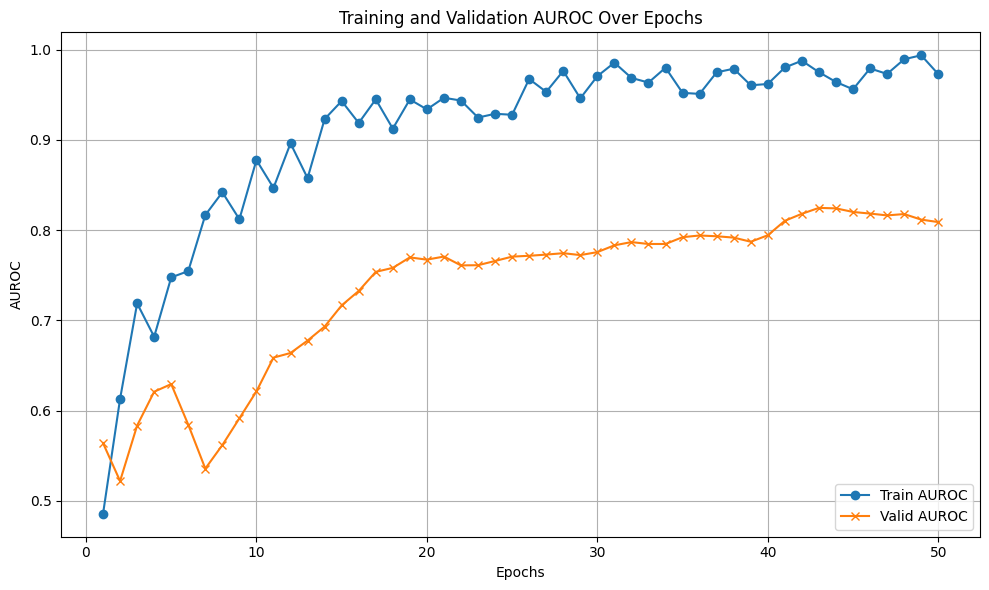

In [ ]:
def plot_auroc(history):
    """
    Plots the training and validation AUROC from the training history.

    Args:
        history (dict): Training history containing 'Train AUROC' and 'Valid AUROC' as keys.
    """
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(history["Train AUROC"]) + 1)

    # Plot Train and Validation AUROC
    plt.plot(epochs, history["Train AUROC"], label="Train AUROC", marker='o')
    plt.plot(epochs, history["Valid AUROC"], label="Valid AUROC", marker='x')
    plt.xlabel("Epochs")
    plt.ylabel("AUROC")
    plt.title("Training and Validation AUROC Over Epochs")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.tight_layout()

    plt.show()

# Example Usage
plot_auroc(history)